In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import utils
pi = 3.14159265

## ECC based alignment

In [ ]:
d0m = cv2.imread('polar_grab/d0.tif')
d45m = cv2.imread('polar_grab/d45_m.tif')
d90m = cv2.imread('polar_grab/d90_m.tif')

d0m = cv2.cvtColor(d0m, cv2.COLOR_BGR2GRAY)
d45m = cv2.cvtColor(d45m, cv2.COLOR_BGR2GRAY)
d90m = cv2.cvtColor(d90m, cv2.COLOR_BGR2GRAY)

In [1]:
import face0
import face005
import face015
import face_015
import face0dm
import facem015

In [6]:
# The first step of alignment process is based on https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/
def eccaligner(d0m, d45m):
    sz = d0m.shape
    warp_mode = cv2.MOTION_HOMOGRAPHY
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    number_of_iterations = 5000
    termination_eps = 1e-10
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    (cc, warp_matrix) = cv2.findTransformECC (d0m,d45m, warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        im2_aligned = cv2.warpPerspective (d45m, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        im2_aligned = cv2.warpAffine(d45m, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned

In [4]:
imface0 = np.zeros(facem015.data.shape)
imface0 = facem015.data * 255/(1)
cv2.imwrite('align_out/temp2.jpg', imface0)

True

In [2]:
im1 = cv2.imread('face_render/face0.png')
im2 = cv2.imread('face_render/facexm005.png')

In [8]:
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
# im1[face0dm.data==0] = 0
# im2[face0dm.data==0] = 0
im2_aligned = eccaligner(im1, im2)
cv2.imwrite('align_out/temp3.png', im2_aligned)

True

## Stereo 

In [163]:
def disp2pc (disp):
    xs = np.zeros((disp.shape[0]*disp.shape[1], 1))
    ys = np.zeros((disp.shape[0]*disp.shape[1], 1))
    zs = np.zeros((disp.shape[0]*disp.shape[1], 1))
    i = 0
    for x in range(0, disp.shape[1]):
        for y in range(0, disp.shape[0]):
            if (disp[y,x]>50):
                xs[i] = x
                ys[i] = y
                zs[i] = disp[y,x]
                i = i + 1
    return (xs,ys,zs)

In [4]:
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [5]:
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)
disparity = stereo.compute(im1,im2)
cv2.imwrite('align_out/disp.jpg', disparity)

True

In [161]:
disp = np.load('align_out/face0_out.npy')
disp.shape

(1024, 1024)

<IPython.core.display.Javascript object>


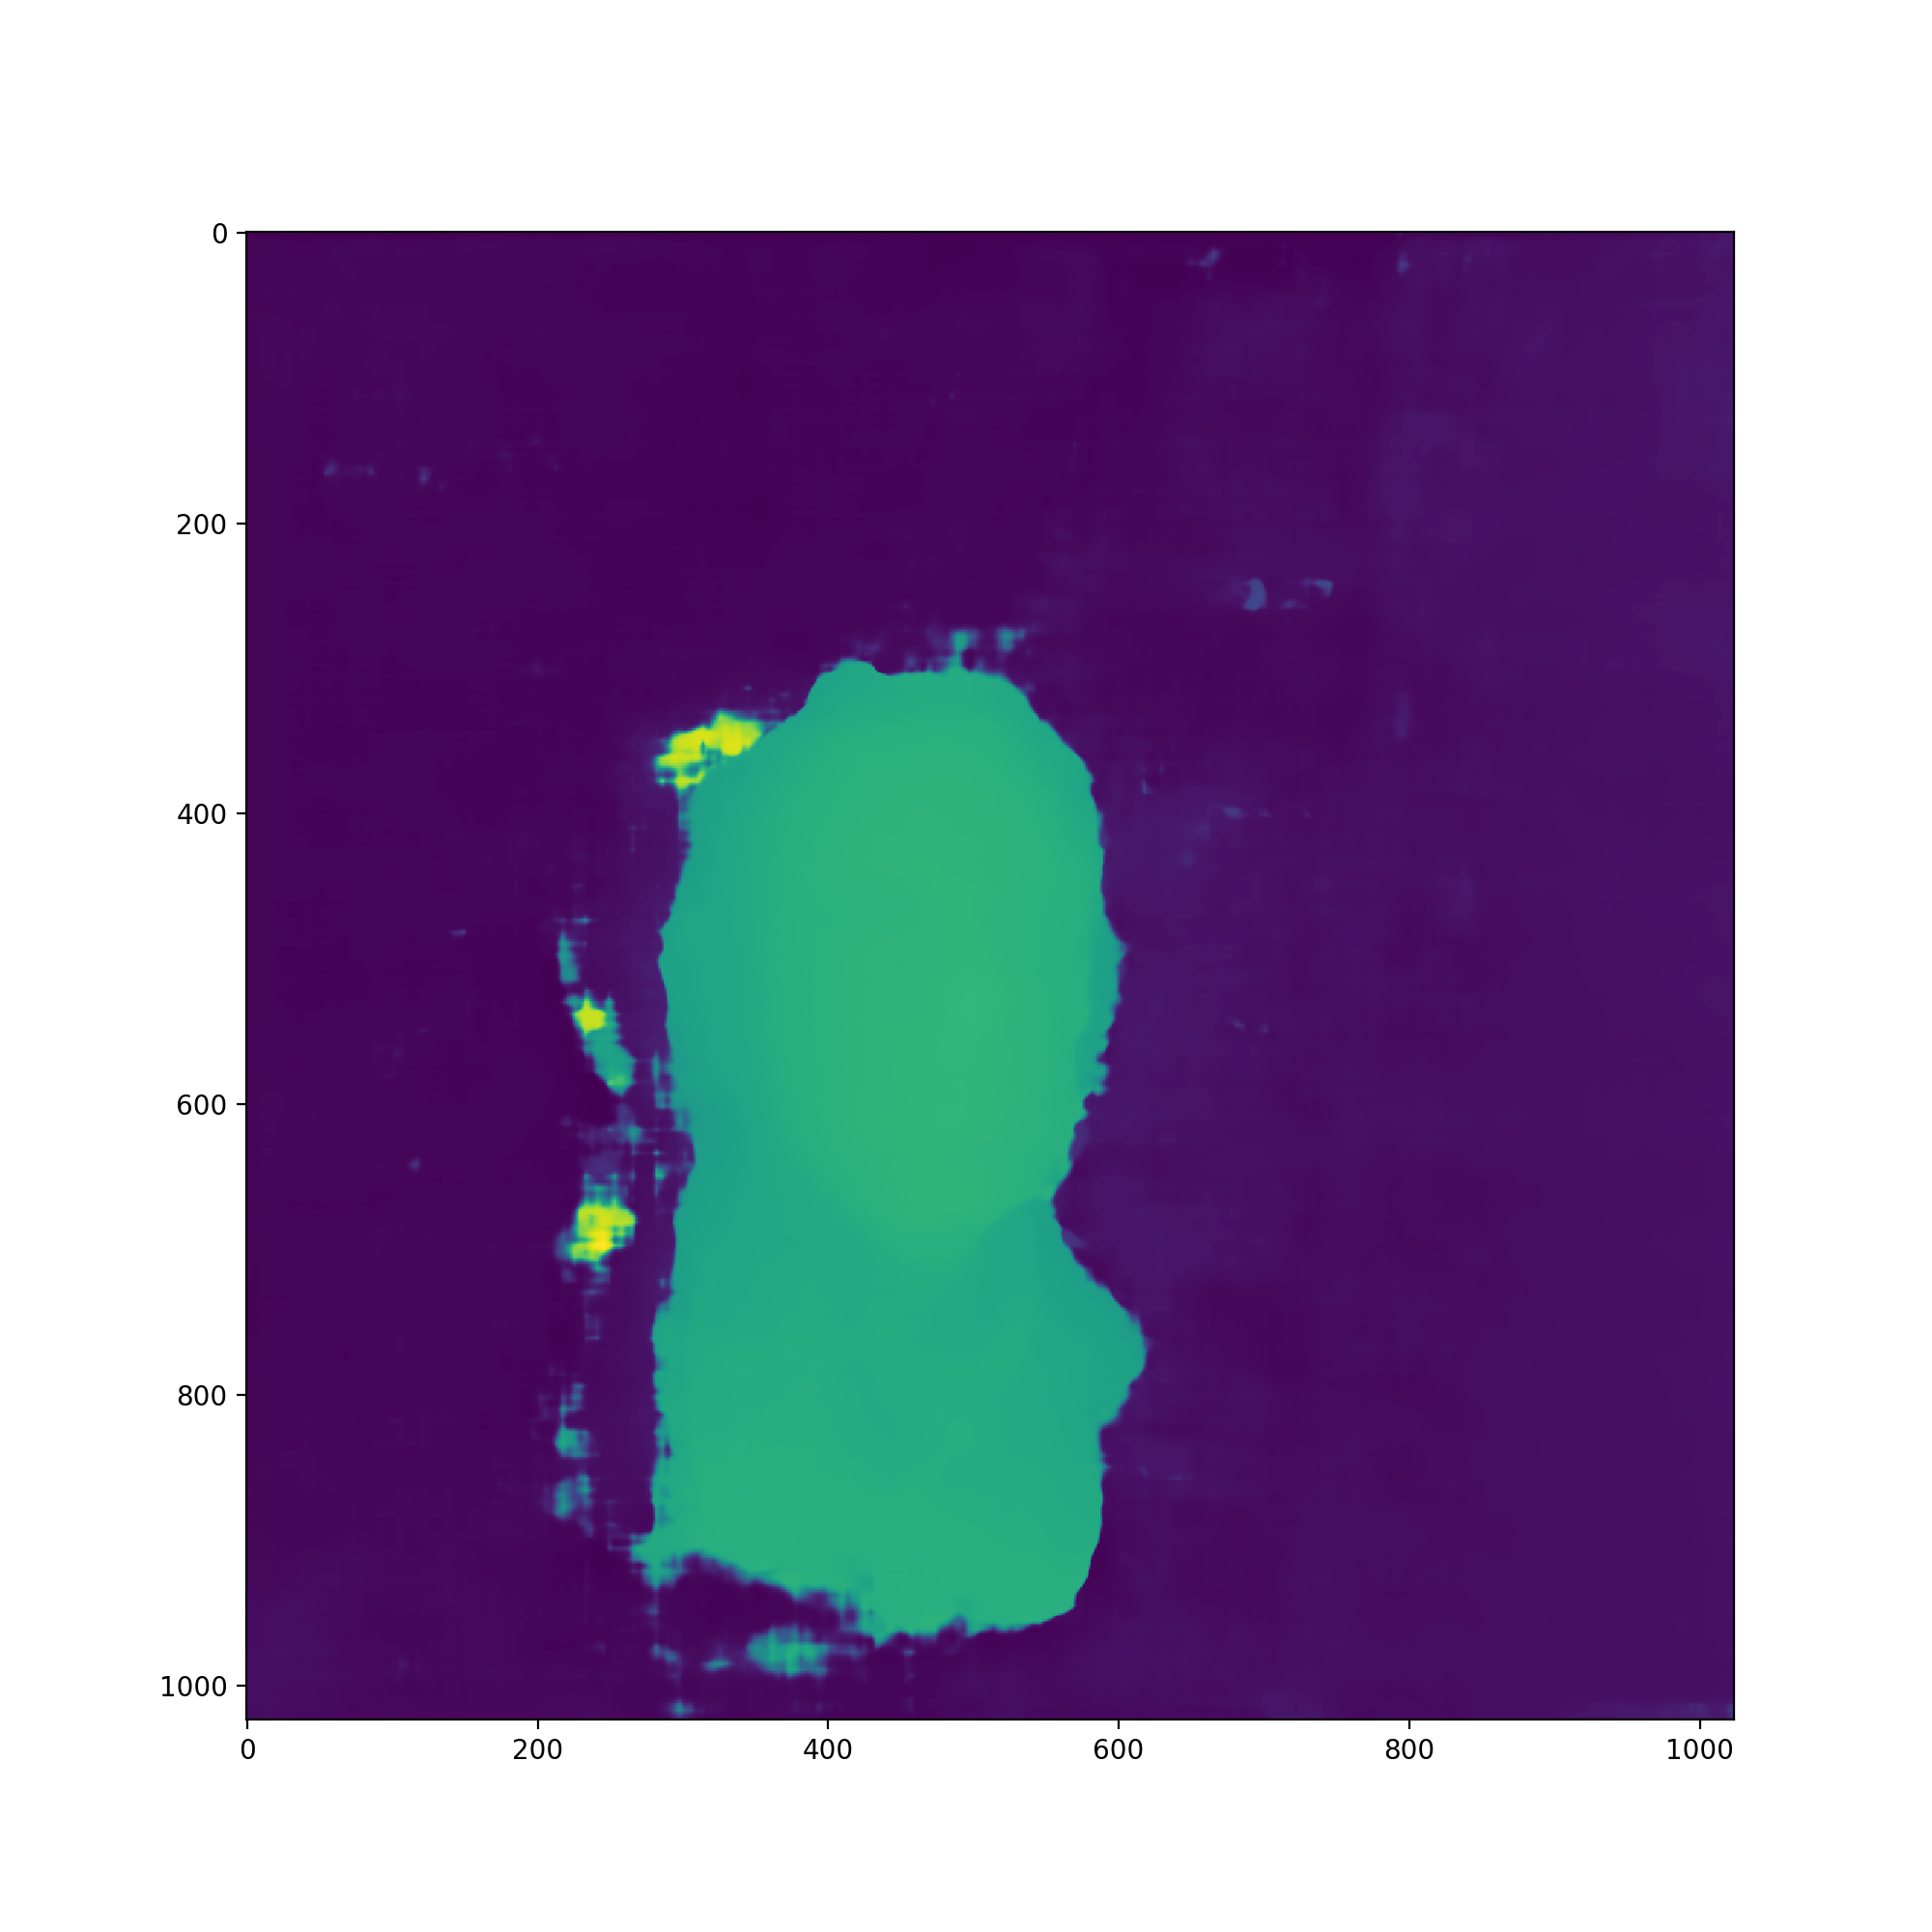

In [162]:
# disp = cv2.imread('align_out/face0_out.png')
# disp = cv2.cvtColor(disp, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(disp)
plt.show()

In [37]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [164]:
xs,ys,zs = disp2pc(disp)
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(xs, ys, zs, marker='.')
# plt.show()

In [47]:
from plyfile import PlyData, PlyElement

In [52]:
el = PlyElement.describe(np.hstack((xs,ys,zs)), 'face')
PlyData([el]).write('face.ply')

ValueError: only one-dimensional arrays are supported

In [153]:
plydata = PlyData.read('/home/vaheta/builds/mve/scene/surface-L2-clean.ply')

In [154]:
plydata.elements[0].data

memmap([(-1.3719143 , 0.8659517, 9.790472, 28, 24, 32, 77.53641  , 0.01051907),
        (-1.3710794 , 0.865718 , 9.79022 , 28, 24, 32, 77.146126 , 0.01049394),
        (-1.364923  , 0.8614455, 9.791342, 28, 25, 32, 75.0317   , 0.01043164),
        ...,
        ( 0.5828257 , 1.9781908, 9.457265, 29, 24, 31, 13.697828 , 0.01326288),
        ( 0.5881474 , 1.9781908, 9.456641, 24, 21, 27, 11.7944565, 0.01113123),
        ( 0.44446102, 2.217668 , 9.454145, 25, 21, 28, 10.297767 , 0.01256205)],
       dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'), ('confidence', '<f4'), ('value', '<f4')])

In [68]:
fa = np.array([([0, 1, 2], 255, 255, 255),
                     ([0, 2, 3], 255,   0,   0),
                     ([0, 1, 3],   0, 255,   0),
                     ([1, 2, 3],   0,   0, 255)])

In [96]:
vertex = np.array([(0, 0, 0),
...                       (0, 1, 1),
...                       (1, 0, 1),
...                       (1, 1, 0)],
...                      dtype=[('x', 'f4'), ('y', 'f4'),
...                             ('z', 'f4')])

In [135]:
fatemp

array([(0., 0., 0.)], dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

In [145]:
fa

array([(52., 214., 20.221344), (52., 215., 20.136547),
       (52., 216., 20.025404), ..., ( 0.,   0.,  0.      ),
       ( 0.,   0.,  0.      ), ( 0.,   0.,  0.      )],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

In [173]:
el = PlyElement.describe(fa, 'vertex')
PlyData([el], text=True).write('some_binary.ply')

In [167]:
arr = np.hstack((xs,ys,zs))

In [79]:
fa= np.array(arr, dtype=[('x', 'f4'), ('y', 'f4'),
...                             ('z', 'f4')])

In [ ]:
fas = []
N = len(arr)
for k in range(0,9):
    fatemp = np.array([(arr[int((k/10)*N),0], arr[int((k/10)*N),1], arr[int((k/10)*N),2])], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    for i in range(int((k/10)*N)+1,int((k+1/10)*N)):
        if i%100000 == 0:
            print (i)
        fatempest = np.array([(arr[i,0], arr[i,1], arr[i,2]*20)], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
        fatemp = np.append(fa, fatempest)
    fas.append(fatemp)

fa = np.array([(arr[0,0], arr[0,1], arr[0,2])], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])     
for fatemp in fas:
    fa = np.append(fa,fatemp)

In [172]:
N = len(arr)
fa = np.array([(arr[0,0], arr[0,1], arr[0,2])], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])  
for i in range(1,N):
    if i%100000 == 0:
        print (i)
    if (arr[i,0]==0): 
        continue
    fatempest = np.array([(arr[i,0], arr[i,1], arr[i,2]*20)], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    fa = np.append(fa, fatempest)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [93]:
fa = np.array((arr[:,0], arr[:,1], arr[:,2]), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
arr.dtype(('x', 'f4'), ('y', 'f4'), ('z', 'f4'))

ValueError: setting an array element with a sequence.

## SIFT based matcher

In [5]:
# Initiate SIFT detector
sift = cv2.SIFT()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(d0m,None)
kp2, des2 = sift.detectAndCompute(d45m,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(d0m,kp1,img2,kp2,good,flags=2)
plt.imshow(img3),plt.show()

AttributeError: module 'cv2' has no attribute 'SIFT'

In [6]:
temp = cv2.imread('polar_grab/d0.tif')
cv2.imwrite('align_out/temp.png', temp)

True

## Aligned photos polar processing

In [ ]:
d0 = cv2.imread('polar_grab/d0.tif')
d45 = cv2.imread('polar_grab/d45.tif')
d90 = cv2.imread('polar_grab/d90.tif')

d0 = cv2.cvtColor(d0, cv2.COLOR_BGR2GRAY)
d45 = cv2.cvtColor(d45, cv2.COLOR_BGR2GRAY)
d90 = cv2.cvtColor(d90, cv2.COLOR_BGR2GRAY)

imgs = np.stack([d0, d45, d90], axis=2)
xvals = np.mat([0, pi/4, pi/2])
n = 1.6

phi, theta, ro = utils.polarimgs2norms(imgs, xvals, n)